In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.modeling.models import BlackBody

from dust_extinction.parameter_averages import G23
from scipy.optimize import curve_fit
from scipy import stats
from iminuit import Minuit 

# File loading & Postprocessing (Binning + De-extinction)

In [2]:
# Load file
file = fits.open('../coadded_1dspec.fits')
print(file.info())

Filename: ../coadded_1dspec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   ()      
  1  SPECTRUM      1 BinTableHDU     33   3403R x 5C   [1D, 1D, 1D, 1D, 1K]   
None


In [3]:
data = file[1].data
print(data.columns)

ColDefs(
    name = 'wave'; format = '1D'
    name = 'wave_grid_mid'; format = '1D'
    name = 'flux'; format = '1D'
    name = 'ivar'; format = '1D'
    name = 'mask'; format = '1K'
)


In [4]:
wave = data.wave
flux = data.flux
noise = 1./np.sqrt(data.ivar)

In [5]:
binfactor=4
subarray_flux = flux[:(flux.size // binfactor) * binfactor].reshape(-1, binfactor)
subarray_noise = noise[:(noise.size // binfactor) * binfactor].reshape(-1, binfactor)
wavebin = wave[:(wave.size // binfactor) * binfactor].reshape(-1, binfactor).mean(axis=1)

fluxbin = np.average(subarray_flux, weights=1/(subarray_noise)**2, axis=1)
noisebin = np.sqrt(1/((1/subarray_noise**2).sum(axis=1)))

#Unextinguish
ext = G23(Rv=3.1)
fluxbin /= ext.extinguish(wavebin*u.AA, Av=0.239)

# Blackbody separate fitting, then blackbody + power-law (OBSOLETE)

First we attempt to find the suitable values for the blackbody curve to use for fitting the blackbody + power-law fit.

(OBSOLETE: We fit all of the parameters in the last segment, at the same time (besides, this might not have been as viable anyways!)).

In [6]:
#def chi_sq_func_blackbody(wavebin, fluxbin, noisebin, temp_guess_values, scale_guess_values, cutoff_max):
    #'''Function that calculates the temp and scaling factor of the blackbody function from minimum chi^2'''
    #xdata = np.linspace(4200, cutoff_max, 1000)
    
    #chi2_surface = np.zeros((len(temp_guess_values),len(scale_guess_values)))
    
    #for i,temp_try in enumerate(temp_guess_values):
        #for j,scale_try in enumerate(scale_guess_values):
            #y_mod_try          = function_bb(wavebin, temp_try, scale_try)
            #chi2_surface[j,i]  = np.sum((fluxbin - y_mod_try)**2/noisebin**2)
        
    #temp_lowest_chi = np.where(chi2_surface == np.min(chi2_surface))[1][0]
    #scale_lowest_chi = np.where(chi2_surface == np.min(chi2_surface))[0][0]
    
    #temp = temp_guess_values[temp_lowest_chi]
    #scale = scale_guess_values[scale_lowest_chi]
    
    #ydata = function_bb(xdata, temp, scale)
    
    ### Calculating likelihood ###
    #likelihood = np.exp(-chi2_surface/2.) 
    #likelihood /= np.sum(likelihood)
    
    #prob_temp  = np.sum(likelihood, axis=0)
    #prob_temp /= np.trapz(prob_temp, temp_guess_values)

    #prob_scale  = np.sum(likelihood, axis=1)
    #prob_scale /= np.trapz(prob_scale, scale_guess_values)
    
    ### Final values + Errors of 1 standard deviation! ###
    #best_temp = np.trapz(prob_temp*temp_guess_values, temp_guess_values)
    #sigma_temp = np.sqrt(np.trapz(prob_temp*(temp_guess_values-best_temp)**2, temp_guess_values))
    
    #best_scale = np.trapz(prob_scale*scale_guess_values, scale_guess_values)
    #sigma_scale = np.sqrt(np.trapz(prob_scale*(scale_guess_values-best_scale)**2, scale_guess_values))
    
    #Errors = [sigma_temp, sigma_scale]
    #Chisq = np.min(chi2_surface)
    #par = [temp, scale]
    
    #Calculate residuals!
    #residuals = fluxbin - function_bb(wavebin, temp, scale)
    #return xdata, ydata, par, Chisq, residuals, chi2_surface

In [7]:
#temp_guess_values = np.linspace(5000, 6000, 500)
#scale_guess_values = np.linspace(0.5*1e-7, 1.2*1e-6, 500)

#xdata, ydata, par, Chisq, residuals, chi2_surface = chi_sq_func_blackbody(wave, flux, noise, temp_guess_values, scale_guess_values, 9000.)

#plt.contourf(temp_guess_values, scale_guess_values, chi2_surface, levels=700, cmap='viridis')
#plt.xlabel("Temperature [K]")
#plt.ylabel("Scaling factor [A.U.]")
#plt.title("Chi-squared 2D Surface - Blackbody constants")
#cbar = plt.colorbar()
#cbar.set_label('$\chi^2$')

#plt.plot(par[0],par[1], 'r*', ms=10, label="Min. chi squared = {}".format(int(np.min(chi2_surface))))
#plt.legend()
#print("Best temp: " + str(par[0]))
#print("Best scalefactor: " + str(par[1]))

#COMMENTED OUT - THIS TAKES A LONG TIME TO RUN!

In [8]:
#def function(x, a, k):#Power-law function to curve fit to
    #bb_lam = BlackBody(5596*u.K, scale=2.01*1e-7 * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
    #spectrum = bb_lam(x)
    #return a*x**k + spectrum.to_value()
    
#def chi2_owncalc(a, k):
    #y_fit = function(wavebin, a, k)
    #chi2 = np.sum(((fluxbin - y_fit) / noisebin)**2)
    #return chi2

In [9]:
#def curve_fit_func(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max):
    #minuit_chi2 = Minuit(chi2_owncalc, a=1e9, k=-2)
    #minuit_chi2.errordef = 1.0
    #minuit_chi2.migrad()
    
    #fit_a, fit_k = minuit_chi2.values[:]
    
    #xdata = np.linspace(cutoff_min, cutoff_max, 1000)
    #ydata = function(xdata, fit_a, fit_k)
    #fluxbin_model = function(wavebin, fit_a, fit_k)
    #Chisq = minuit_chi2.fval
    
    #Ndof = len(fluxbin) - minuit_chi2.nfit
    #red_Chisq = Chisq/(Ndof)
    #Prob_value = stats.chi2.sf(red_Chisq, 1) 
    #print(Ndof, Prob_value)
    
    #Calculate residuals!
    #residuals = fluxbin - function(wavebin, fit_a, fit_k)
    #return xdata, ydata, minuit_chi2.values[:], minuit_chi2.errors[:], Chisq, residuals, Ndof, Prob_value

In [10]:
#cutoff_min = 4200
#cutoff_max = 9000.
#save=True

#fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

#xdata, ydata, par, Errors, Chisq, residuals, Ndof, Prob_value  = curve_fit_func(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max)
#ax1.text(6800, 0.90, '$A = ({} \pm {}) \cdot 10^8$  '.format(round(par[0]/1e8, 2), round(Errors[0]/1e8, 2)), fontsize="xx-large", color="red")
#ax1.text(6800, 0.85, '$\lambda = {} \pm {}$  '.format(round(par[1], 2), round(Errors[1], 2)), fontsize="xx-large", color="red")
#ax1.text(6800, 0.8, '$P(\chi^2={}, Ndof={}) = {}$  '.format(int(Chisq), Ndof, round(Prob_value, 3)), fontsize="xx-large", color="red")
#ax1.set_title("GRB230307A - Flux as a func of wavelength, {}Å to {}Å, binfactor={} - dereddened".format(cutoff_min, cutoff_max, binfactor))

#bb_lam = BlackBody(5596*u.K, scale=2.01*1e-7 * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
#spectrum = bb_lam(xdata)


#ax1.set_ylabel("Flux [1e-17 erg/s/cm^2/AA]") #Arbitrary units
#ax1.step(wavebin,fluxbin, label="GRB230307A Flux", color="blue")
#ax1.step(wavebin,noisebin,color='green', label="Noise")
#ax1.plot(xdata, ydata, "--", color="red", label="Blackbody + Power-law fit")
#ax1.set_xlim(cutoff_min,cutoff_max)
#ax1.set_ylim(-0.2,1.)
#ax1.plot(xdata, spectrum, color="pink", label="Blackbody")
#ax1.plot(xdata, )
#ax1.legend()

#ax2.set_xlabel("Wavelength [Å]")
#ax2.set_ylabel("Residuals [A.U.]")
#ax2.plot(wavebin, residuals, ".", color="black", alpha=0.5, label="Residuals")
#ax2.plot(xdata, np.zeros(1000), "-.", color="orange", label="Best-fit model line")
#ax2.legend()
#ax2.set_ylim(-1, 1.)

#fig.set_size_inches(12, 10)
#plt.tight_layout()
#if save==True:
#    plt.savefig("Bb_and_p_l-graph-raw-data_{}Å-to-{}Å_dereddened.png".format(cutoff_min, cutoff_max), dpi=200)

# Blackbody (from Yang et. al) temperature parameter + scaling for blackbody and power-law (both exponent + scaling)

Combination of blackbody and power law. Blackbody temperature for transient at t=2.4 days determined by figure 3, p. 9, "A lanthanide-rich kilonova in the aftermath of a long gamma-ray burst" (Yang, et. al.). Temperature is proportional to t^(-0.54) and in the observed period t=2.4 determined to be in the ballpark of roughly 4000 Kelvin. We now set the temperature parameter to this, and proceed with fitting the rest!

In [21]:
def scaling_function(x, a, k, m):#Power-law function to curve fit to
    global T
    bb_lam = BlackBody(T*u.K, scale=m * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
    spectrum = bb_lam(x)
    return a*x**k + spectrum.to_value()

def chi2_owncalc(a, k, m):
    y_fit = scaling_function(wavebin, a, k, m)
    chi2 = np.sum(((fluxbin - y_fit) / noisebin)**2)
    return chi2

In [22]:
def curve_fit_func_scaling(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max, guess_val):
    minuit_chi2 = Minuit(chi2_owncalc, a=guess_val[0], k=guess_val[1], m=guess_val[2])
    minuit_chi2.errordef = 1.0
    minuit_chi2.migrad()
    
    fit_a, fit_k, fit_m = minuit_chi2.values[:]
    
    xdata = np.linspace(cutoff_min, cutoff_max, 1000)
    ydata = scaling_function(xdata, fit_a, fit_k, fit_m)
    
    fluxbin_model = scaling_function(wavebin, fit_a, fit_k, fit_m)
    Chisq = minuit_chi2.fval
    Ndof = len(fluxbin) - minuit_chi2.nfit
    red_Chisq = Chisq/Ndof
    Prob_value = stats.chi2.sf(red_Chisq, 1) #Integrals over the chi-square function to obtain probability can be hard with
    #this number of values. To make the computation easier, the reduced chi-square is used, and the number of degrees of freedom
    #is equally divided (and therefore set to 1).
    
    #Calculate residuals!
    residuals = fluxbin - scaling_function(wavebin, fit_a, fit_k, fit_m)
    return xdata, ydata, minuit_chi2.values[:], minuit_chi2.errors[:], Chisq, residuals, Ndof, Prob_value

In [23]:
def plotting(wavebin, fluxbin, noisebin, format_text, sig_digits, guess_val, cutoff_min = 4200, cutoff_max = 9000.):
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)


    xdata, ydata, par, Errors, Chisq, residuals, Ndof, Prob_value = curve_fit_func_scaling(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max, guess_val)
    ax1.set_title("GRB230307A - Flux as a func of wavelength, {}Å to {}Å, binfactor={} - dereddened".format(cutoff_min, cutoff_max, binfactor))
    ax1.text(6800, 0.90, format_text[0].format(round(par[0]/format_text[1], sig_digits[0]), round(Errors[0]/format_text[1], sig_digits[0])), fontsize="xx-large", color="red")
    ax1.text(6800, 0.85, format_text[2].format(round(par[1]/format_text[3], sig_digits[1]), round(Errors[1]/format_text[3], sig_digits[1])), fontsize="xx-large", color="red")
    ax1.text(6800, 0.8,  format_text[4].format(round(par[2]/format_text[5], sig_digits[2]), round(Errors[2]/format_text[5], sig_digits[2])), fontsize="xx-large", color="red")
    ax1.text(6800, 0.75, '$P(\chi^2={}, Ndof={}) = {}$  '.format(int(Chisq), Ndof, round(Prob_value, 3)), fontsize="xx-large", color="red")
    
    
    bb_lam = BlackBody(T*u.K, scale=par[2] * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
    spectrum = bb_lam(xdata)


    ax1.set_ylabel("Flux $10^{-17}$ [$erg \cdot s^{-1} \cdot cm^{-2} \cdot Å^{-1}$]") #Arbitrary units
    ax1.step(wavebin,fluxbin, label="GRB230307A Flux", color="blue")
    ax1.step(wavebin,noisebin,color='green', label="Noise")
    
    ax1.plot(xdata, ydata, "-", color="red", linewidth=2, label="Blackbody + Power-law fit")
    ax1.set_xlim(cutoff_min,cutoff_max)
    ax1.set_ylim(-0.2,1.)
    ax1.plot(xdata, spectrum, "--", linewidth=2, color="pink", label="Blackbody")
    ax1.plot(xdata, par[0]*xdata**par[1], "--", linewidth=2, color="orange", label="Power-law")
    ax1.legend(loc="lower right")
    ax1.grid()

    ax2.set_xlabel("Wavelength [Å]")
    ax2.set_ylabel("Residuals [A.U.]")
    ax2.plot(wavebin, residuals, ".", color="black", alpha=0.5, label="Residuals")
    ax2.plot(xdata, np.zeros(1000), "-.", color="orange", label="Best-fit model line")
    ax2.legend(loc="lower right")
    ax2.set_ylim(-1, 1.)
    ax2.grid()

    fig.set_size_inches(12, 10)
    plt.tight_layout()
    if save==True:
        plt.savefig("Bb_and_p_l-graph-raw-data_{}Å-to-{}Å_dereddened.png".format(cutoff_min, cutoff_max), dpi=200)
    return

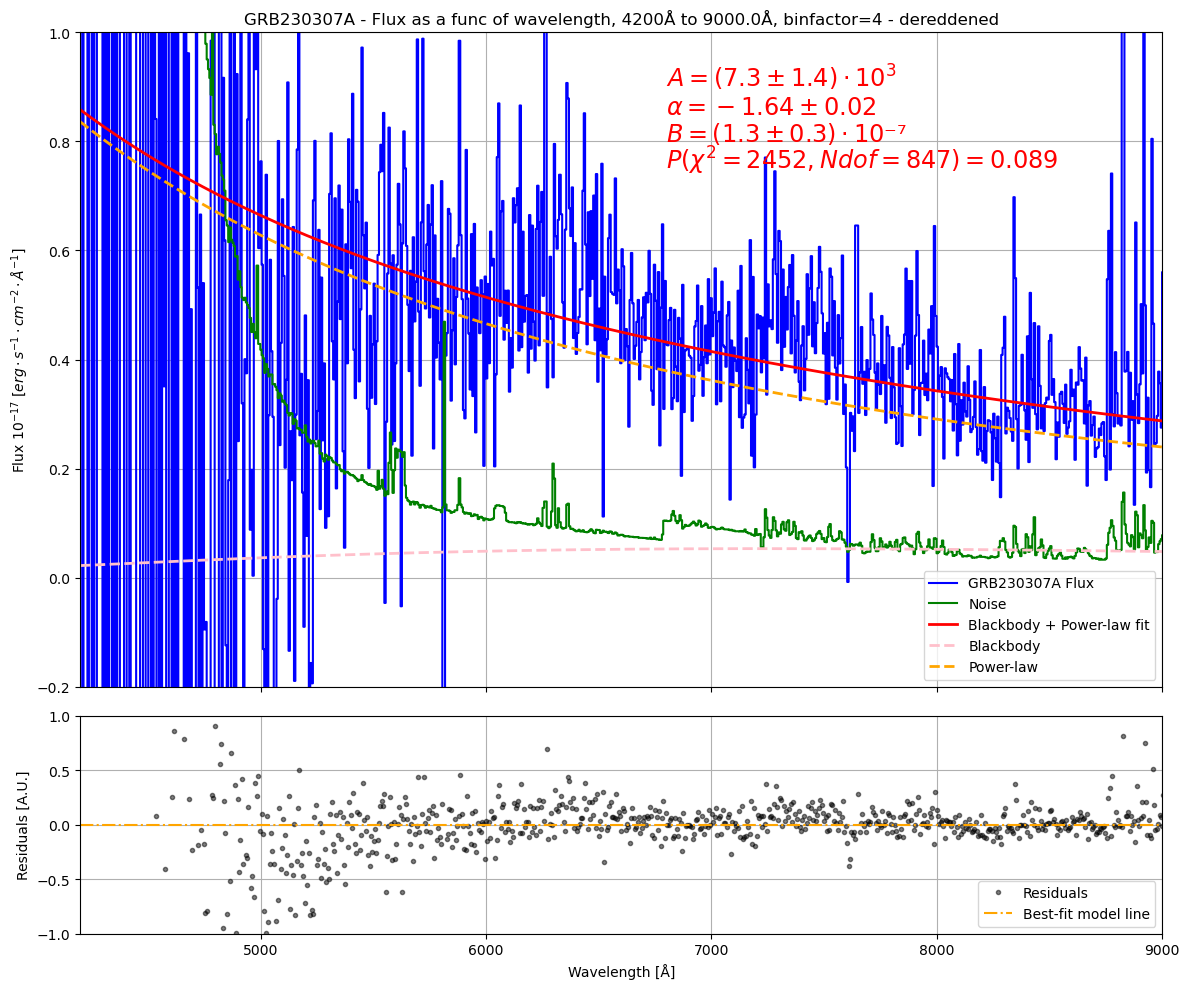

In [26]:
T = 4000
save=False

format_text = ['$A = ({} \pm {}) \cdot 10^3$', 1e5, '$α = {} \pm {}$', 1, '$B = ({} \pm {}) \cdot 10⁻⁷ $', 1e-7]
sig_digits = [1, 2, 1]
plotting(wavebin, fluxbin, noisebin, format_text, sig_digits, [1e5, -1.5, 5e-10], cutoff_min = 4200, cutoff_max = 9000.)

# Fitting for everything except temperature (~6700K)

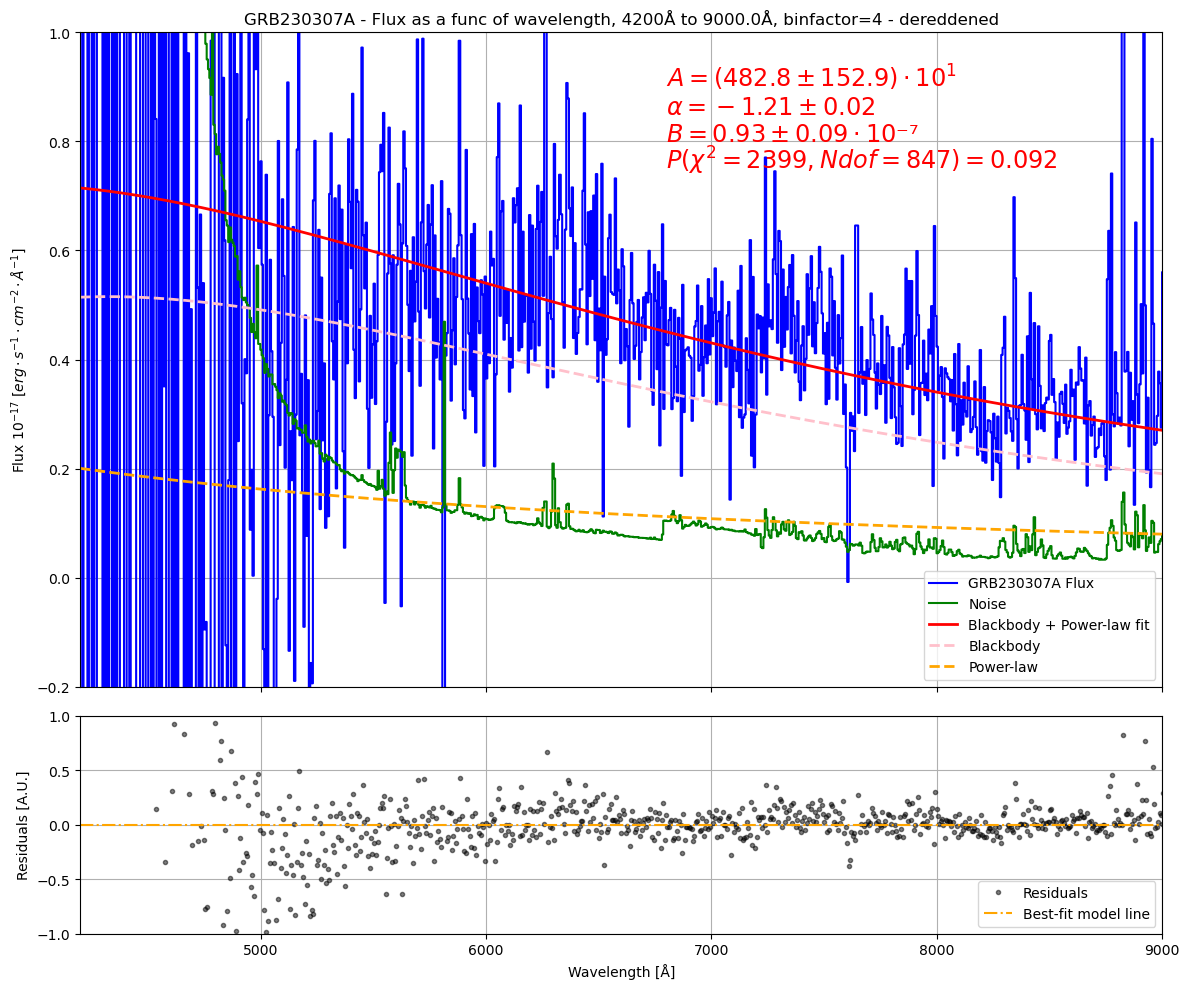

In [25]:
T = 6700
save=False

format_text = ['$A = ({} \pm {}) \cdot 10^1$', 1e1, '$α = {} \pm {}$', 1, '$B = {} \pm {} \cdot 10⁻⁷ $', 1e-7]
sig_digits = [1, 2, 2]
#plotting(wavebin, fluxbin, noisebin, format_text, sig_digits, [1000, -2, 1e-8])
plotting(wavebin, fluxbin, noisebin, format_text, sig_digits, [1e5, -1.5, 5e-10])

# Fitting for everything

In [16]:
def scaling_function3(x, a, k, m, T):#Power-law function to curve fit to
    bb_lam = BlackBody(T*u.K, scale=1* u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
    spectrum = bb_lam(x)
    return a*x**k + m*spectrum.to_value()
    
def chi2_owncalc3(a, k, m, T):
    y_fit = scaling_function3(wavebin, a, k, m, T)
    chi2 = np.sum(((fluxbin - y_fit) / noisebin)**2)
    return chi2

In [17]:
def curve_fit_func_scaling3(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max):
    minuit_chi2 = Minuit(chi2_owncalc3, a=1e5, k=-1.5, m=5e-10, T=6000)
    minuit_chi2.errordef = 1.0
    minuit_chi2.migrad()
    
    fit_a, fit_k, fit_m, fit_T = minuit_chi2.values[:]
    
    Ndof = len(fluxbin) - minuit_chi2.nfit
    Chisq = minuit_chi2.fval
    red_Chisq = Chisq/Ndof
    Prob_value = stats.chi2.sf(red_Chisq, 1)
    
    xdata = np.linspace(cutoff_min, cutoff_max, 1000)
    ydata = scaling_function3(xdata, fit_a, fit_k, fit_m, fit_T)
    fluxbin_model = scaling_function3(wavebin, fit_a, fit_k, fit_m, fit_T)

    #Calculate residuals!
    residuals = fluxbin - scaling_function3(wavebin, fit_a, fit_k, fit_m, fit_T)
    return xdata, ydata, minuit_chi2.values[:], minuit_chi2.errors[:], Chisq, residuals, Ndof, Prob_value

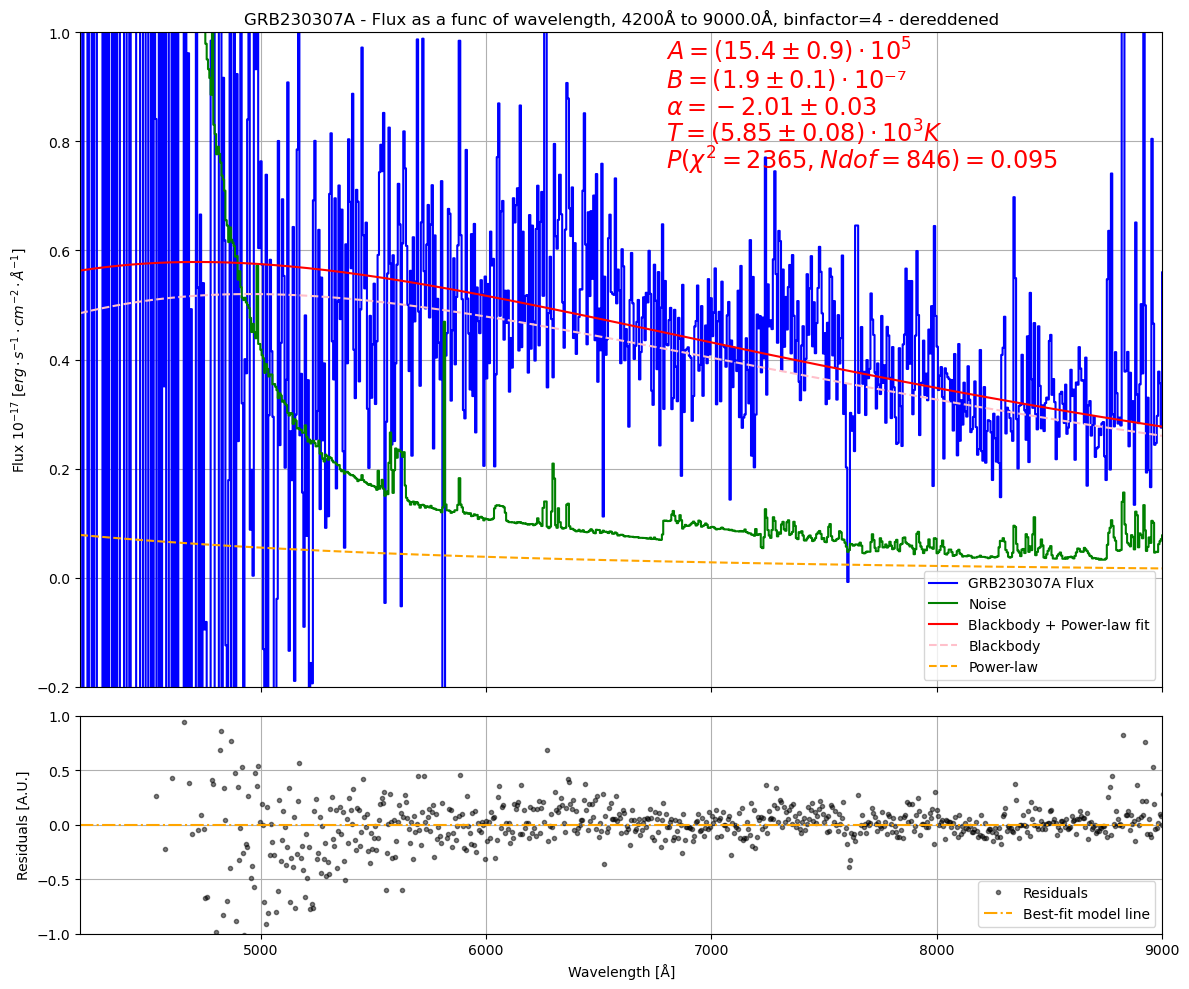

In [18]:
cutoff_min = 4200
cutoff_max = 9000.
save=False

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)


xdata, ydata, par, Errors, Chisq, residuals, Ndof, Prob_value = curve_fit_func_scaling3(wavebin, fluxbin, noisebin, cutoff_min, cutoff_max)
ax1.text(6800, 0.95, '$A = ({} \pm {}) \cdot 10^5$  '.format(round(par[0]/1e5, 1), round(Errors[0]/1e5, 1)), fontsize="xx-large", color="red")
ax1.text(6800, 0.90, '$B = ({} \pm {}) \cdot 10⁻⁷ $'.format(round(par[2]*1e7, 1), round(Errors[2]*1e7, 1)), fontsize="xx-large", color="red")
ax1.text(6800, 0.85, '$α = {} \pm {}$  '.format(round(par[1], 2), round(Errors[1], 2)), fontsize="xx-large", color="red")
ax1.text(6800, 0.8, '$T = ({} \pm {}) \cdot 10^3 K$  '.format(round(par[3]/1e3, 2), round(Errors[3]/1e3, 2)), fontsize="xx-large", color="red")
ax1.text(6800, 0.75, '$P(\chi^2={}, Ndof={}) = {}$  '.format(int(Chisq), Ndof, round(Prob_value, 3)), fontsize="xx-large", color="red")
ax1.set_title("GRB230307A - Flux as a func of wavelength, {}Å to {}Å, binfactor={} - dereddened".format(cutoff_min, cutoff_max, binfactor))

bb_lam = BlackBody(par[3]*u.K, scale=par[2] * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
spectrum = bb_lam(xdata)


ax1.set_ylabel("Flux $10^{-17}$ [$erg \cdot s^{-1} \cdot cm^{-2} \cdot Å^{-1}$]") #Arbitrary units
ax1.step(wavebin,fluxbin, label="GRB230307A Flux", color="blue")
ax1.step(wavebin,noisebin,color='green', label="Noise")
ax1.plot(xdata, ydata, color="red", label="Blackbody + Power-law fit")
ax1.set_xlim(cutoff_min,cutoff_max)
ax1.set_ylim(-0.2,1.)
ax1.plot(xdata, spectrum, "--", color="pink", label="Blackbody")
ax1.plot(xdata, par[0]*xdata**par[1], "--", color="orange", label="Power-law")
ax1.legend(loc="lower right")
ax1.grid()

ax2.set_xlabel("Wavelength [Å]")
ax2.set_ylabel("Residuals [A.U.]")
ax2.plot(wavebin, residuals, ".", color="black", alpha=0.5, label="Residuals")
ax2.plot(xdata, np.zeros(1000), "-.", color="orange", label="Best-fit model line")
ax2.legend(loc="lower right")
ax2.set_ylim(-1, 1.)
ax2.grid()

fig.set_size_inches(12, 10)
plt.tight_layout()
if save==True:
    plt.savefig("Bb_and_p_l-graph-binfactor4_{}Å-to-{}Å_dereddened.png".format(cutoff_min, cutoff_max), dpi=200)

# Exploring the Chi^2 landscape for the fit-parameters

In [19]:
def chi2_fitting(wavebin, a, k, m, T):
    y_fit = scaling_function3(wavebin, a, k, m, T)
    chi2 = np.sum(((fluxbin - y_fit) / noisebin)**2)
    return chi2

C:\Users\Lenti\AppData\Local\Temp\ipykernel_20176\4131503239.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  plt.plot(par[0], chi2_fitting(wavebin, par[0], par[1], par[2], par[3]), "r*", label="Best-fit A = {} $\cdot 10^6$".format(round(par[0]/1e6,2)), color="blue")
C:\Users\Lenti\AppData\Local\Temp\ipykernel_20176\4131503239.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  plt.plot(par[1], chi2_fitting(wavebin, par[0], par[1], par[2], par[3]), "r*", label="Best-fit α = {}".format(round(par[1], 2)), color="blue")
C:\Users\Lenti\AppData\Local\Temp\ipykernel_20176\4131503239.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  plt.plot(par[2], ch

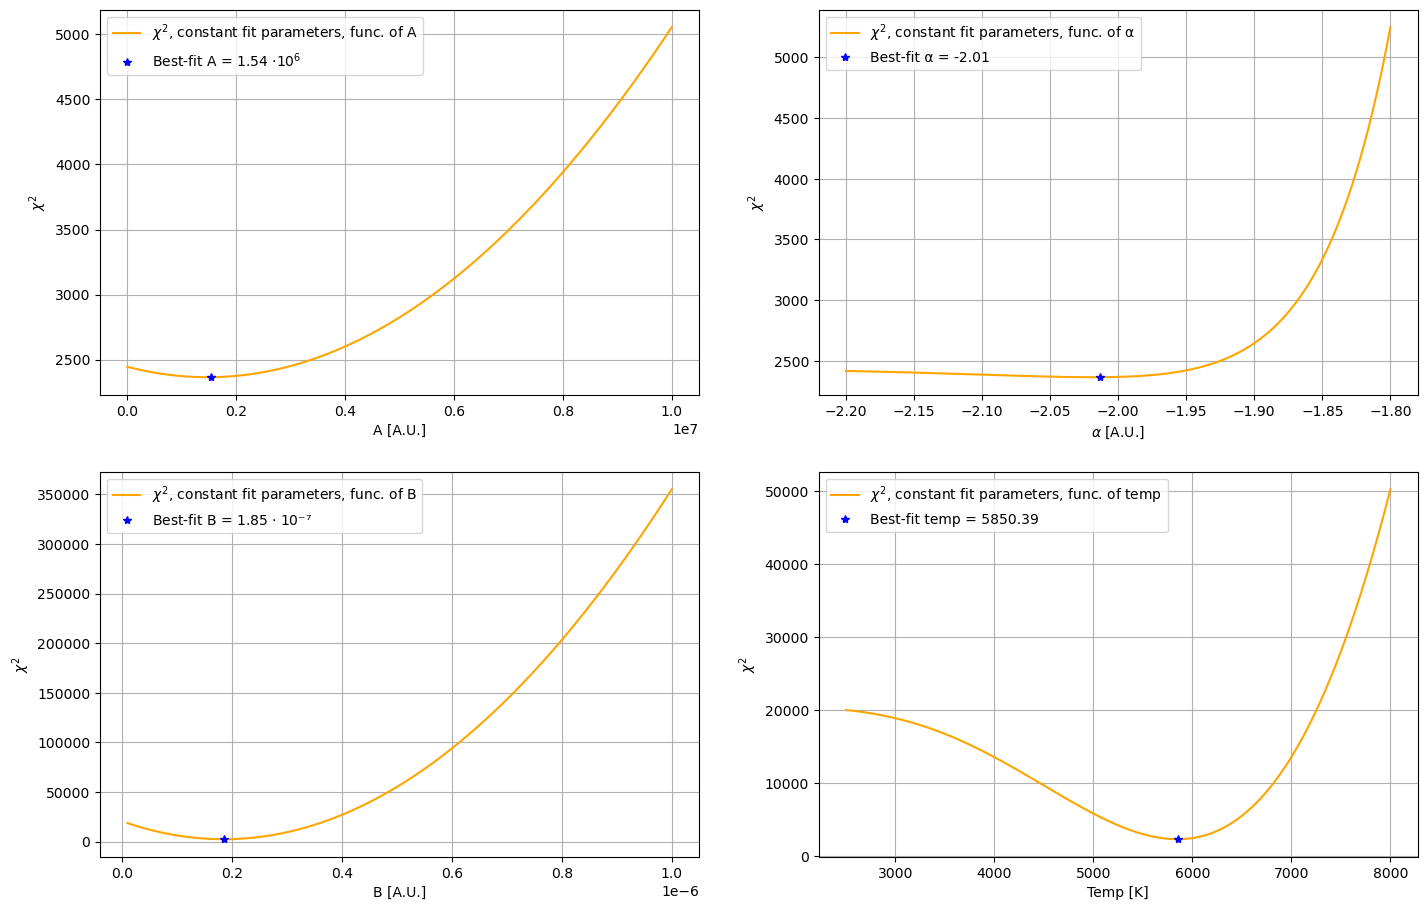

In [20]:
fig = plt.figure(figsize=(17, 11))
rows = 2
columns = 2
save=False

fig.add_subplot(rows, columns, 1)
A_range = np.linspace(1e3, 1e7, len(wavebin))
chi2_range = []
for i in A_range:
    chi2_range.append(chi2_fitting(wavebin, i, par[1], par[2], par[3])) 
plt.plot(A_range, chi2_range, label="$\chi^{2}$, constant fit parameters, func. of A", color="orange")
plt.plot(par[0], chi2_fitting(wavebin, par[0], par[1], par[2], par[3]), "r*", label="Best-fit A = {} $\cdot 10^6$".format(round(par[0]/1e6,2)), color="blue")
plt.ylabel("$\chi^{2}$")
plt.xlabel("A [A.U.]")
plt.legend(loc="upper left")
plt.grid()

fig.add_subplot(rows, columns, 2)
alpha_range = np.linspace(-1.8, -2.2, len(wavebin))
chi2_range = []
for i in alpha_range:
    chi2_range.append(chi2_fitting(wavebin, par[0], i, par[2], par[3])) 
plt.plot(alpha_range, chi2_range, label="$\chi^{2}$, constant fit parameters, func. of α", color="orange")
plt.plot(par[1], chi2_fitting(wavebin, par[0], par[1], par[2], par[3]), "r*", label="Best-fit α = {}".format(round(par[1], 2)), color="blue")
plt.ylabel("$\chi^{2}$")
plt.xlabel("$α$ [A.U.]")
plt.legend(loc="upper left")
plt.grid()

fig.add_subplot(rows, columns, 3)
B_range = np.linspace(1e-8, 1e-6, len(wavebin))
chi2_range = []
for i in B_range:
    chi2_range.append(chi2_fitting(wavebin, par[0], par[1], i, par[3])) 
plt.plot(B_range, chi2_range, label="$\chi^{2}$, constant fit parameters, func. of B", color="orange")
plt.plot(par[2], chi2_fitting(wavebin, par[0], par[1], par[2], par[3]), "r*", label="Best-fit B = {} $\cdot$ 10⁻⁷".format(round(par[2]*1e7, 2)), color="blue")
plt.ylabel("$\chi^{2}$")
plt.xlabel("B [A.U.]")
plt.legend(loc="upper left")
plt.grid()

fig.add_subplot(rows, columns, 4)
temp_range = np.linspace(2500, 8000, len(wavebin))
chi2_range = []
for i in temp_range:
    chi2_range.append(chi2_fitting(wavebin, par[0], par[1], par[2], i)) 
plt.plot(temp_range, chi2_range, label="$\chi^{2}$, constant fit parameters, func. of temp", color="orange")
plt.plot(par[3], chi2_fitting(wavebin, par[0], par[1], par[2], par[3]), "r*", label="Best-fit temp = {}".format(round(par[3], 2)), color="blue")
plt.ylabel("$\chi^{2}$")
plt.xlabel("Temp [K]")
plt.legend(loc="upper left")
plt.grid()

if save==True:
    plt.savefig("Bb_and_p_l-chi2-landscape.png", dpi=300)

### Overall, it is very hard to determine the exact fits for the transient. Most of the fits end with a p-value that is close to 0.1 (and usually, for a hypothesis testing, it is desirable for the p-value to be above 0.1 to accept the chance hypothesis). But this is clearly a borderline case, and therefore it is hard to say for sure. Closest to this value came with the parameters given in the "all parameters fitted" case, where temperature is somewhere between the 4000K and 6700K case.